# Single Type Experiment

In [24]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm
import os
import sys
import importlib
import numpy as np
import nbformat
import pandas as pd
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd


from radar_plot import radar_factory, normalize
from algorithms_single import *

### Scaling with n

In [37]:
data = []

algo_list = {'Static Allocation': fixed_threshold,
             'Guarded Hope $L_T = T^{-1/2}$': lambda a,b,c,d: hope_guardrail(a,b,c,d,1/2),
             'Guarded Hope $L_T = T^{-1/3}$': lambda a,b,c,d: hope_guardrail(a,b,c,d,1/3),
            #  'Resolve CE': hope_online,
            #  'CE': hope_full
            }

num_iterations = 2

# for n in tqdm(np.arange(1, max_n+1, 1000)):


num_groups = np.logspace(2, 20, base=1.5, num=50).astype(int)
expec_size = 1.5

for n in tqdm(num_groups):
    
    mean_size = np.zeros(n) + expec_size
    stdev_size = mean_size
    
    alloc_diff = np.zeros((len(algo_list), n, num_iterations))

    
    for i in range(num_iterations):
        
        size = 1+np.random.poisson(size=n,lam = mean_size-1)
        budget = expec_size * n
        
        # print(size)
        # size = 1+np.random.poisson(size=n,lam = mean_size-1)
        # size = 1 + np.random.normal(size=n, loc = mean_size - 1, scale=.1)
        index = 0        

        opt = offline_opt(budget, size, mean_size, stdev_size)

        for algo in algo_list:
            sol = algo_list[algo](budget, size, mean_size, stdev_size)

            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'L1', 'Value': np.sum(np.abs(opt-sol))}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Linf', 'Value': np.max(np.abs(opt-sol))}
            data.append(data_dict)
            alloc_diff[index, :, i] = opt - sol
            if np.around(budget - np.dot(size, sol), 3) < 0:
                print('ERROR: ' + str(algo))
                print(np.dot(size, sol), budget)

            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Waste', 'Value': (budget - np.dot(size, sol))}
            data.append(data_dict)

            index += 1

    index = 0
    for algo in algo_list:
        data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Ex-Ante Envy', 'Value': np.max(np.mean(np.abs(alloc_diff[index, :, :]), axis=1))}
        data.append(data_dict)
        index += 1

    
    
    

  0%|          | 0/50 [00:00<?, ?it/s]

In [38]:
df = pd.DataFrame.from_records(data)
# df.to_csv('./data/single_poisson.csv', index=False)
# df = pd.read_csv('./data/single_poisson.csv')

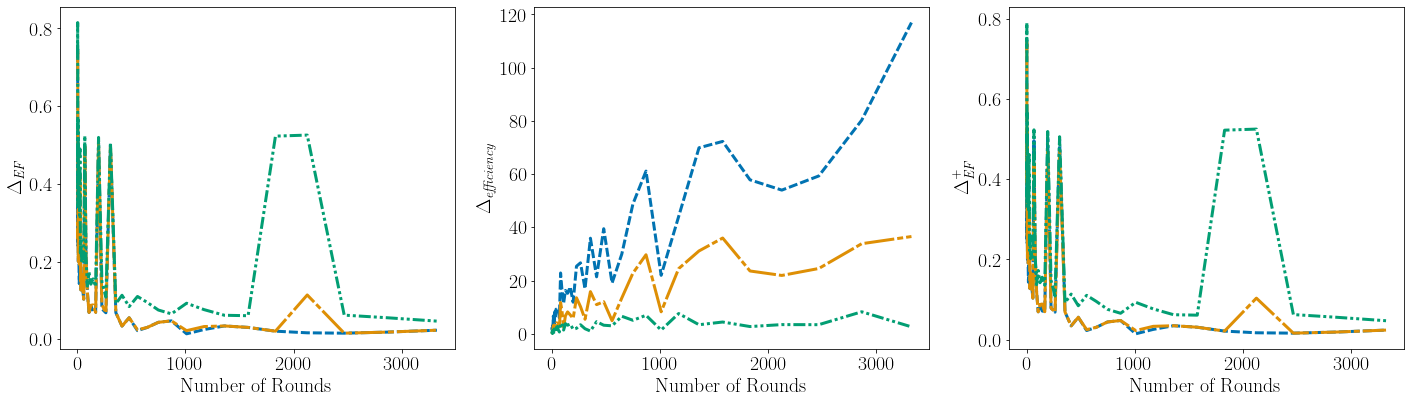

In [39]:


df.columns


plt.style.use('PaperDoubleFig.mplstyle.txt')
# Make some style choices for plotting 
# colorWheel =['#2bd1e5',
#             '#281bf5',
#              '#db1bf5',
#              '#F5CD1B',
#             '#FF5733','#9cf51b',]
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]


#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#plt.figure(figsize=(20,10))
#plt.title('Simple Distribution L1')
#sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

# filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
# dash_styles = ["",
#                (4, 1.5),
#                (1, 1),
#                (3, 1, 1.5, 1),
#                (5, 1, 1, 1),
#                (5, 1, 2, 1, 2, 1),
#                (2, 2, 3, 1.5),
#                (1, 2.5, 3, 1.2)]

# fig = plt.figure(figsize=(20,6))
plt.rc('text', usetex=True)



fg, axs = plt.subplots(1,3, sharex='all', figsize=(20,6))
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'Linf'], ax = axs[0], linewidth=3, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Waste'], ax = axs[1], linewidth=3, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)

sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Ex-Ante Envy'], ax = axs[2], linewidth=3, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)



axs[0].get_legend().remove()
axs[0].set_ylabel(r'$\Delta_{\it EF}$')
axs[0].set_xlabel(r'Number of Rounds')

axs[1].set_ylabel(r'$\Delta_{\it efficiency}$')
axs[1].set_xlabel(r'Number of Rounds')
axs[1].get_legend().remove()

axs[2].get_legend().remove()
axs[2].set_ylabel(r'$\Delta_{\it EF}^+$')
axs[2].set_xlabel(r'Number of Rounds')


# axs[2].legend(ncol = 3, loc= 'upper right', bbox_to_anchor=(0.5, -.15))


# legend = axs[2].legend(ncol = 5, loc= 'lower center', bbox_to_anchor=(-1, -.3, 0.5, 0.5))
# print(len(legend.get_lines()))
# [legend.get_lines()[i].set_linewidth(3) for i in range(len(legend.get_lines()))]


plt.show()
fg.savefig('./figures/poisson_single.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)

# axs[2].legend(ncol=5, loc='center', bbox_to_anchor=(0.5, 0.5), prop={"size":50})
# plt.show()

In [40]:
def export_legend(legend, filename="LABEL_ONLY.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)


3


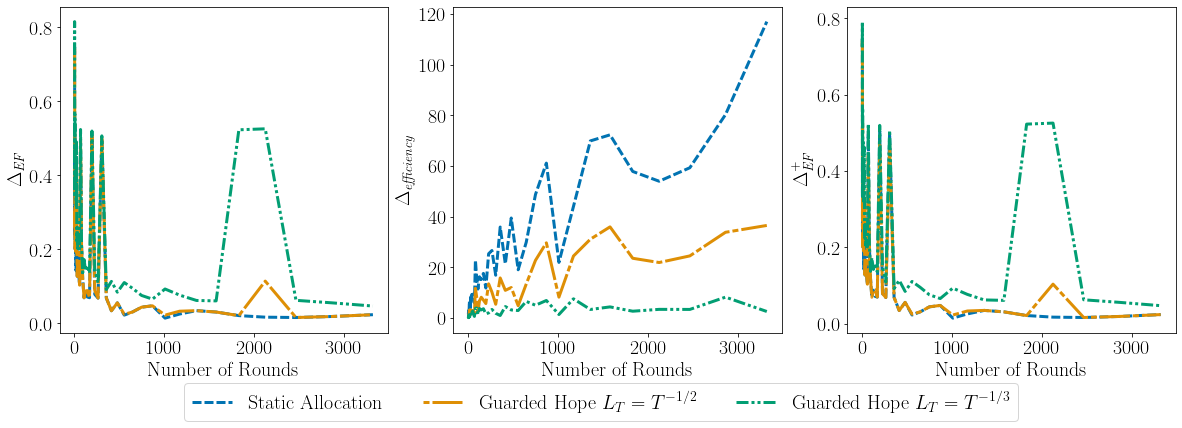

In [41]:


df.columns


plt.style.use('PaperDoubleFig.mplstyle.txt')
# Make some style choices for plotting 
# colorWheel =['#2bd1e5',
#             '#281bf5',
#              '#db1bf5',
#              '#F5CD1B',
#             '#FF5733','#9cf51b',]
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]


#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#plt.figure(figsize=(20,10))
#plt.title('Simple Distribution L1')
#sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

# filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
# dash_styles = ["",
#                (4, 1.5),
#                (1, 1),
#                (3, 1, 1.5, 1),
#                (5, 1, 1, 1),
#                (5, 1, 2, 1, 2, 1),
#                (2, 2, 3, 1.5),
#                (1, 2.5, 3, 1.2)]

# fig = plt.figure(figsize=(20,6))
plt.rc('text', usetex=True)



fg, axs = plt.subplots(1,3, sharex='all', figsize=(20,6))
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'Linf'], ax = axs[0], linewidth=3, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Waste'], ax = axs[1], linewidth=3, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)

sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Ex-Ante Envy'], ax = axs[2], linewidth=3, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)



axs[0].get_legend().remove()
axs[0].set_ylabel(r'$\Delta_{\it EF}$')
axs[0].set_xlabel(r'Number of Rounds')

axs[1].set_ylabel(r'$\Delta_{\it efficiency}$')
axs[1].set_xlabel(r'Number of Rounds')
axs[1].get_legend().remove()

axs[2].get_legend().remove()
axs[2].set_ylabel(r'$\Delta_{\it EF}^+$')
axs[2].set_xlabel(r'Number of Rounds')


# axs[2].legend(ncol = 3, loc= 'upper right', bbox_to_anchor=(0.5, -.15))


legend = axs[2].legend(ncol = 5, loc= 'lower center', bbox_to_anchor=(-1, -.3, 0.5, 0.5))
print(len(legend.get_lines()))
[legend.get_lines()[i].set_linewidth(3) for i in range(len(legend.get_lines()))]

export_legend(legend)

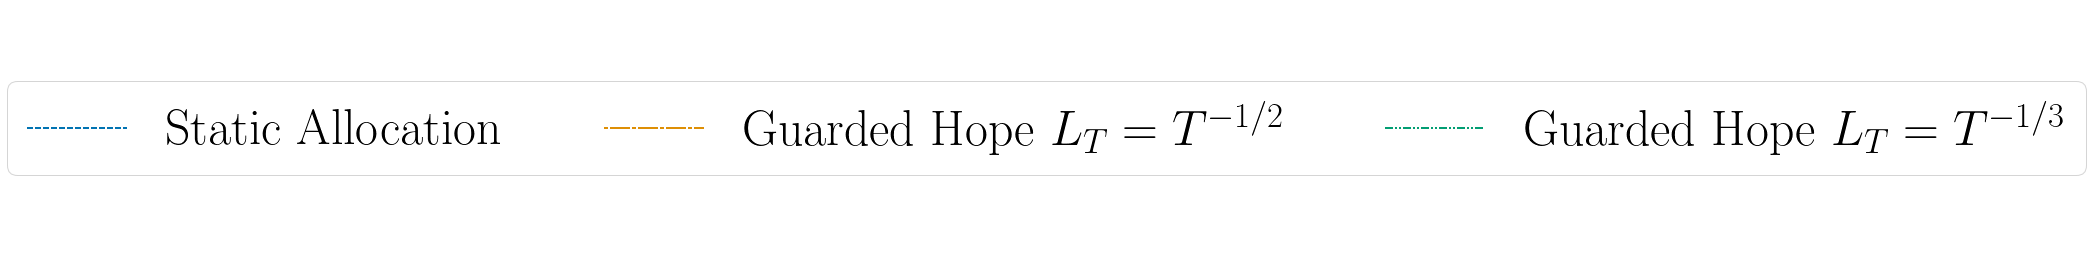

In [42]:
label_params = axs[0].get_legend_handles_labels() 

figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, ncol = 5, loc="center", bbox_to_anchor=(0.5, 0.5), prop={"size":50})
figl.savefig("LABEL_ONLY_2.pdf", bbox_inches = 'tight')

### Group by Group Difference

In [11]:
fair_data = []
loc_data = []


n = 500
num_iterations = 200



expec_size = 1.5

alloc_diff = np.zeros((len(algo_list), n, num_iterations))

for i in tqdm(range(num_iterations)):
    
    mean_size = np.zeros(n) + expec_size
    stdev_size = mean_size
    
    

    

    size = 1+np.random.poisson(size=n,lam = mean_size-1)
    budget = expec_size * n

    # print(size)
    # size = 1+np.random.poisson(size=n,lam = mean_size-1)
    # size = 1 + np.random.normal(size=n, loc = mean_size - 1, scale=.1)
    index = 0               
            
    opt = offline_opt(budget, size, mean_size, stdev_size)
    for algo in algo_list:
        sol = algo_list[algo](budget, size, mean_size, stdev_size)
        
        
        alloc_diff[index, :, i] = opt - sol
        index += 1
        for j in range(n):
            loc_data.append({'Location':j, 'Algorithm':algo, 'Value': opt[j] - sol[j]})
        nsw = (np.prod(np.power(np.asarray(sol), np.asarray(size))))**(1 / np.sum(size))
        fair_data.append({'Iteration':i, 'Algorithm':algo, 
                          '$\Delta_{\it efficiency}$':(budget - np.dot(size, sol)), 
                          '$\Delta_{\it Prop}$':((budget / np.sum(size)) - np.min(sol)),
                          '\textsc{NSW}'.encode('unicode_escape').decode('utf'): nsw,
                          '\textsc{Envy}'.encode('unicode_escape').decode('utf'):(np.max(sol) - np.min(sol)), 
                          '$\Delta_{\it EF}$': np.max(np.abs(sol-opt))}) 
    
            
    for i in range(n):
        loc_data.append({'Location': i, 'Algorithm':'Zero', 'Value': 0})
                         

index = 0
for algo in algo_list:
    data_dict = {'Algorithm':algo, 'Iteration': 1, '$\Delta_{\it EF}^+$': np.max(np.mean(np.abs(alloc_diff[index, :, :]), axis=1))}
    fair_data.append(data_dict)
    index += 1

  0%|          | 0/200 [00:00<?, ?it/s]

In [6]:
# fair_df = pd.DataFrame.from_records(fair_data)
# fair_df.to_csv('./data/single_poisson_fair.csv', index=False)
fair_df = pd.read_csv('./data/single_poisson_fair.csv')

### Printing Fairness Metrics

In [7]:
fair_df = fair_df.groupby(['Algorithm']).mean()

fair_df = fair_df.drop(['Iteration'], axis=1)
print(fair_df)


fair_df['$\Delta_{\it efficiency}$'] = (-1)*fair_df['$\Delta_{\it efficiency}$']
fair_df['\textsc{Envy}'.encode('unicode_escape').decode('utf')] = (-1)*fair_df['\textsc{Envy}'.encode('unicode_escape').decode('utf')]
fair_df['$\Delta_{\it EF}$'] = (-1)* fair_df['$\Delta_{\it EF}$']
fair_df['$\Delta_{\it Prop}$'] = (-1) * fair_df['$\Delta_{\it Prop}$']
fair_df['$\Delta_{\it EF}^+$'] = (-1)*fair_df['$\Delta_{\it EF}^+$']

                            $\Delta_{\it efficiency}$  $\Delta_{\it Prop}$  \
Algorithm                                                                    
Fixed Threshold                          3.260326e+01             0.053355   
Hope Full                                3.606941e+00             0.479919   
Hope Guardrail $L_T = 1/2$               1.304099e+01             0.080950   
Hope Guardrail $L_T = 1/3$               4.401751e+00             0.128188   
Hope Online                              9.094947e-15             0.217249   

                            \textsc{NSW}  \textsc{Envy}  $\Delta_{\it EF}$  \
Algorithm                                                                    
Fixed Threshold                 0.947457       0.009566           0.053355   
Hope Full                       0.547295       0.495932           0.479978   
Hope Guardrail $L_T = 1/2$      0.953965       0.081964           0.082362   
Hope Guardrail $L_T = 1/3$      0.914968       0.222357        

In [8]:
fair_df = normalize(fair_df)
print(fair_df)

                            $\Delta_{\it efficiency}$  $\Delta_{\it Prop}$  \
Algorithm                                                                    
Fixed Threshold                              0.100000             1.000000   
Hope Full                                    0.900432             0.100000   
Hope Guardrail $L_T = 1/2$                   0.640009             0.941778   
Hope Guardrail $L_T = 1/3$                   0.878491             0.842112   
Hope Online                                  1.000000             0.654203   

                            \textsc{NSW}  \textsc{Envy}  $\Delta_{\it EF}$  \
Algorithm                                                                    
Fixed Threshold                 0.896299       1.000000           1.000000   
Hope Full                       0.100000       0.461743           0.397406   
Hope Guardrail $L_T = 1/2$      0.909249       0.919878           0.959028   
Hope Guardrail $L_T = 1/3$      0.831646       0.764506        

In [9]:
fair_df.loc['Hope Full']

$\Delta_{\it efficiency}$    0.900432
$\Delta_{\it Prop}$          0.100000
\textsc{NSW}                 0.100000
\textsc{Envy}                0.461743
$\Delta_{\it EF}$            0.397406
$\Delta_{\it EF}^+$          0.333964
Name: Hope Full, dtype: float64

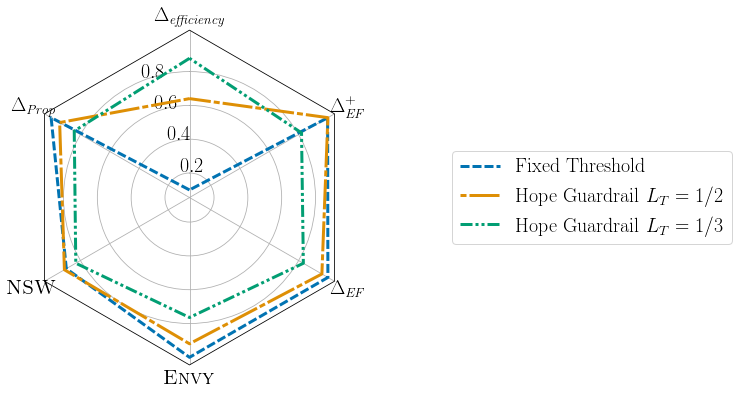

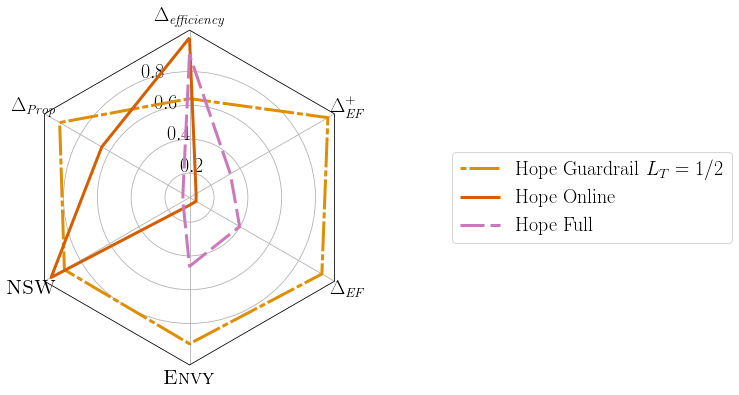

In [10]:
# number of variable


from math import pi
plt.style.use('PaperDoubleFig.mplstyle.txt')

plt.rc('text', usetex=True)




N = len(list(fair_df))
theta = radar_factory(N, frame='polygon')

spoke_labels = list(fair_df)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
# ax.set_title('Comparison of Fairness Metrics',  position=(0.5, 1.1), ha='center')
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]

first_plot = { algo : algo_list[algo] for algo in ['Fixed Threshold', 'Hope Guardrail $L_T = 1/2$', 'Hope Guardrail $L_T = 1/3$']}
second_plot = { algo : algo_list[algo] for algo in ['Hope Guardrail $L_T = 1/2$', 'Hope Online', 'Hope Full']}


index = 0
for algo in first_plot:
    values = fair_df.loc[algo].to_numpy()
    ax.plot(theta, values, linewidth=3, dashes=dashesStyles[index], label=algo, color = sns.color_palette('colorblind', len(algo_list))[index])
    ax.fill(theta, values, color = sns.color_palette('colorblind', len(algo_list))[index],  alpha=0)
    index += 1
ax.set_varlabels(spoke_labels)

plt.legend(loc='right', bbox_to_anchor=(2.15, .5))

plt.savefig('./figures/single_poisson_guardrail_radar.pdf')
plt.show()





fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])


dashesStyles = [
            [2,1,10,1],
            [1000,1],[8,2]]

color_list = [sns.color_palette("colorblind", len(algo_list))[1], sns.color_palette("colorblind", len(algo_list))[3], sns.color_palette("colorblind", len(algo_list))[4]]

index = 0
for algo in second_plot:
    values = fair_df.loc[algo].to_numpy()
    ax.plot(theta, values, linewidth=3, dashes=dashesStyles[index], label=algo, color = color_list[index])
    ax.fill(theta, values, color = sns.color_palette('colorblind', len(algo_list))[index],  alpha=0)
    index += 1
ax.set_varlabels(spoke_labels)

plt.legend(loc='right', bbox_to_anchor=(2.15, .5))

plt.savefig('./figures/single_poisson_heuristic_radar.pdf')
plt.show()


